In [2]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
import snowflake.connector
# to save the trained scaler class
import joblib

#Snowflake connection info
# from config import snowflake_conn_prop

import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



snowflake_conn_prop = {
   "account": "se58322-fsesg",
   "user": "Muhammad Nauman",
   "password": "Muhammad23",
   "role": "DEVELOPER",
   "database": "DL_ESG_DEV",
   "schema": "CUSTOMER",
   "warehouse": "WH_ESG_SUSTAINABILITY",
}

from snowflake.snowpark import version
print(version.VERSION)


connection_paramter = snowflake.connector.connect(account = "se58322-fsesg",
                        user="Muhammad Nauman",
                        password="Muhammad23",
                        role="DEVELOPER",
                        warehouse="WH_ESG_SUSTAINABILITY",
                        ocsp_fail_open=False)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(1, 0, 0)
[Row(CURRENT_WAREHOUSE()='WH_ESG_SUSTAINABILITY', CURRENT_DATABASE()='DL_ESG_DEV', CURRENT_SCHEMA()='CUSTOMER')]


In [3]:
# 
# qry = "SELECT * FROM DL_ESG_DEV.CUSTOMER.CUSTOMER"
qry = 'SELECT * FROM DL_ESG_DEV.ESG.TRIAL_SCO_ESG_262'

df = pd.read_sql(qry, connection_paramter)

esg_df = df.copy()
# articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
esg_df.head(5)

/var/folders/nr/vyfq21gx5pn1p0025dclx97c0000gn/T/ipykernel_72415/2169380206.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(qry, connection_paramter)


,date,asset_id,name,ticker,exchange_iso,exchange_mic,dom_country_iso,dom_region,exch_country_iso,exch_region,economic_sector,industry,esg,esg_e,esg_s,esg_g
0,2018-01-01,196,A. O. Smith Corporation,AOS,NYS,XNYS,USA,North America,USA,North America,Producer Manufacturing,Building Products,55.67,46.93,56.43,62.57
1,2018-01-01,208,Abbott Laboratories,ABT,NYS,XNYS,USA,North America,USA,North America,Health Technology,Medical Specialties,46.78,68.29,72.38,17.89
2,2018-01-01,209,"AbbVie, Inc.",ABBV,NYS,XNYS,USA,North America,USA,North America,Health Technology,Pharmaceuticals: Major,51.41,65.98,62.65,35.37
3,2018-01-01,270,Adobe Inc.,ADBE,NAS,XNAS,USA,North America,USA,North America,Technology Services,Packaged Software,64.47,68.40,67.56,61.60
4,2018-01-01,345,"Akamai Technologies, Inc.",AKAM,NAS,XNAS,USA,North America,USA,North America,Technology Services,Internet Software/Services,57.44,73.85,62.76,49.76


In [7]:
esg_df = esg_df.rename({'ticker': 'TICKER'}, axis=1)  # new method

In [4]:
qry = 'SELECT * FROM DL_ESG_DEV.CUSTOMER.PORTFOLIO'

df_port = pd.read_sql(qry, connection_paramter)

port_df = df_port.copy()
port_df.shape


/var/folders/nr/vyfq21gx5pn1p0025dclx97c0000gn/T/ipykernel_72415/3094664699.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_port = pd.read_sql(qry, connection_paramter)


(40000, 9)

In [17]:
esg_df['TICKER'].unique().shape

(495,)

In [16]:
port_df['TICKER'].unique().shape

(7995,)

In [15]:
data = pd.merge(port_df, esg_df, on='TICKER')
data

,R_ID,P_ID,TICKER,BUY_DATE,BUY_VALUE,SHARES_,CURRENCY,OWNED,ADVISOR_ID,date,...,dom_country_iso,dom_region,exch_country_iso,exch_region,economic_sector,industry,esg,esg_e,esg_s,esg_g
0,2e17e6b1-90fe-4634-976b-4db0f124f3a5,94f20e2e-b0e3-42db-bbca-35e82dab617a,CAT,1653091200000,139,6,JPY,6.8333333333,ddf1d04f-d5a6-4092-950f-fd8849ef68b0,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
1,9f881053-6d86-4543-9028-b193e825ae1a,31c07316-1ba8-4fd6-a2df-06c9c49b931c,CAT,1437868800000,107,5,JPY,88.6666666667,78917e01-5907-43b7-95b1-4237955583ac,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
2,a399dc4e-4e1d-42ad-8d6b-eab6736f6b91,b8847b1c-0cf4-465a-9b64-2944a8f33e05,CAT,1499212800000,141,7,JPY,65.3666666667,a378f1cc-1f9e-444c-87d5-85f381a41020,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
3,b53544c2-93e6-42a1-8517-d941a327c46a,342d576d-4a1d-4452-bc71-b9943f233588,CAT,1623542400000,200,10,JPY,18.1,47167d02-c9c6-43d5-b83b-04c336e45a43,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
4,87379140-d066-4baa-a5e5-70ffa7f25010,4a5fb115-10f8-49d2-86e1-82d60d7d7c79,CAT,1590451200000,163,8,USD,30.6666666667,c69219cf-dcb6-4abe-90b0-ff9debf6a929,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,b938845b-61c4-45c0-b071-fc991aa64fcf,58e31e3e-b311-4681-abe3-e0f4cda490cc,LIN,1626480000000,224,11,EUR,16.9666666667,d288548d-ae45-46e3-b8c2-2059a58324bb,2018-01-01,...,GBR,Europe,DEU,Europe,Process Industries,Chemicals: Specialty,64.71,70.91,73.87,56.78
908,f0dc1321-7018-4f63-817a-39f84c43f276,7fdff6b8-8b0f-440d-a2fe-0b761f4c3704,ORCL,1640044800000,229,11,USD,11.8333333333,17cd0563-2797-4f13-ba12-69530d2f78b3,2018-01-01,...,USA,North America,USA,North America,Technology Services,Packaged Software,46.29,74.10,58.40,31.27
909,dd5ac095-daab-4446-8598-c9a9ce5d4f25,0672f494-796b-47b3-8bc2-9c0e7dc44f6d,ORCL,1358812800000,127,6,JPY,118.8,c86a8b21-bb78-4286-8cda-be52a18b9c83,2018-01-01,...,USA,North America,USA,North America,Technology Services,Packaged Software,46.29,74.10,58.40,31.27
910,a6e6dbab-f1b9-4903-9781-4132574905dc,35461f1f-7b3b-4776-a9c2-31f0e703bd2f,NXPI,1515456000000,204,10,USD,59.2333333333,570e5e08-92f4-4914-b0d9-4521fe94d7a2,2018-01-01,...,NLD,Europe,USA,North America,Electronic Technology,Semiconductors,63.37,71.32,67.99,55.11


In [19]:

# Calculate mean rating of all movies
data.groupby('TICKER')['esg'].mean().sort_values(ascending=False).head()

TICKER
EXPD    69.21
MMM     68.74
PG      68.18
MO      67.83
CL      67.16
Name: esg, dtype: float64

In [21]:
# Calculate count rating of all movies
data.groupby('TICKER')['esg'].count().sort_values(ascending=False).head()

TICKER
CPRT    13
HD      11
SPG     11
CVX     11
F        9
Name: esg, dtype: int64

In [24]:
# creating dataframe with 'rating' count values
ratings = pd.DataFrame(data.groupby('TICKER')['esg'].mean()) 
  
ratings['num of ratings'] = pd.DataFrame(data.groupby('TICKER')['esg'].count())
  
ratings.head()

,esg,num of ratings
TICKER,,
ABBV,51.41,4
ABC,55.37,3
ABT,46.78,4
ADBE,64.47,7
ADI,53.68,7


In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style('white')
%matplotlib inline

<AxesSubplot: >

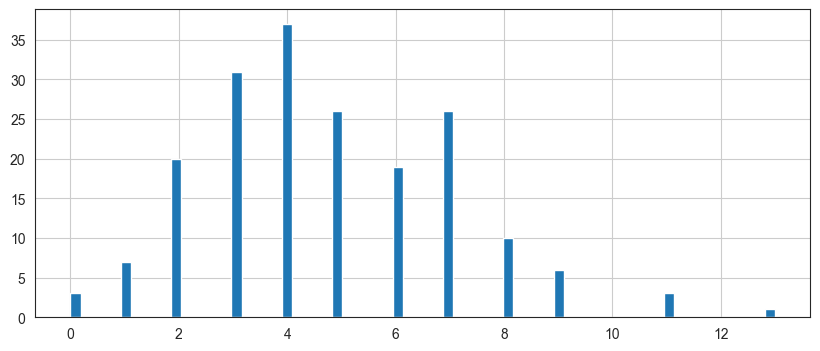

In [26]:

# plot graph of 'num of ratings column'
plt.figure(figsize =(10, 4))
  
ratings['num of ratings'].hist(bins = 70)

<AxesSubplot: >

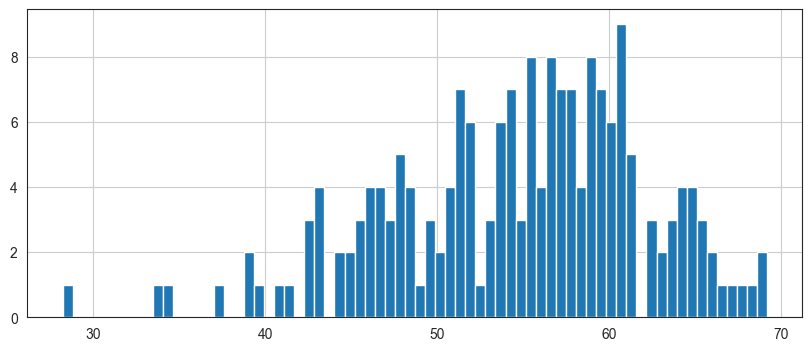

In [28]:

# plot graph of 'ratings' column
plt.figure(figsize =(10, 4))
  
ratings['esg'].hist(bins = 70)

Text(0.5, 1.0, 'Popular Movies')

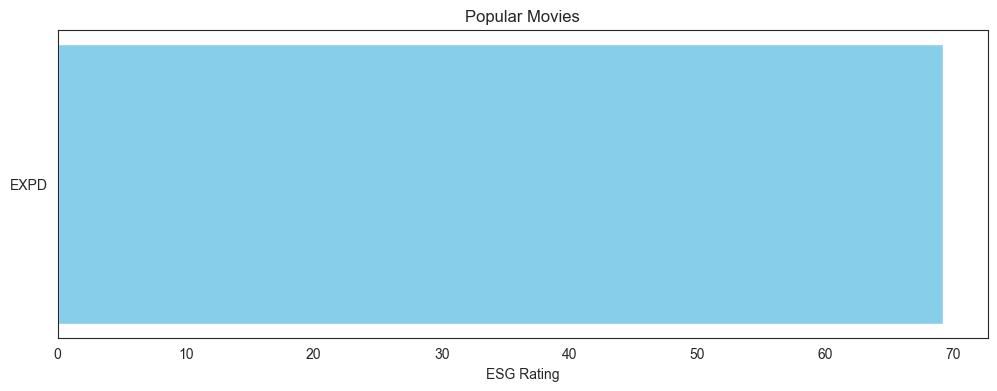

In [48]:
pop= data.sort_values('esg', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['TICKER'].head(6),pop['esg'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("ESG Rating")
plt.title("Popular Movies")

In [29]:
data

,R_ID,P_ID,TICKER,BUY_DATE,BUY_VALUE,SHARES_,CURRENCY,OWNED,ADVISOR_ID,date,...,dom_country_iso,dom_region,exch_country_iso,exch_region,economic_sector,industry,esg,esg_e,esg_s,esg_g
0,2e17e6b1-90fe-4634-976b-4db0f124f3a5,94f20e2e-b0e3-42db-bbca-35e82dab617a,CAT,1653091200000,139,6,JPY,6.8333333333,ddf1d04f-d5a6-4092-950f-fd8849ef68b0,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
1,9f881053-6d86-4543-9028-b193e825ae1a,31c07316-1ba8-4fd6-a2df-06c9c49b931c,CAT,1437868800000,107,5,JPY,88.6666666667,78917e01-5907-43b7-95b1-4237955583ac,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
2,a399dc4e-4e1d-42ad-8d6b-eab6736f6b91,b8847b1c-0cf4-465a-9b64-2944a8f33e05,CAT,1499212800000,141,7,JPY,65.3666666667,a378f1cc-1f9e-444c-87d5-85f381a41020,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
3,b53544c2-93e6-42a1-8517-d941a327c46a,342d576d-4a1d-4452-bc71-b9943f233588,CAT,1623542400000,200,10,JPY,18.1,47167d02-c9c6-43d5-b83b-04c336e45a43,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
4,87379140-d066-4baa-a5e5-70ffa7f25010,4a5fb115-10f8-49d2-86e1-82d60d7d7c79,CAT,1590451200000,163,8,USD,30.6666666667,c69219cf-dcb6-4abe-90b0-ff9debf6a929,2018-01-01,...,USA,North America,USA,North America,Producer Manufacturing,Trucks/Construction/Farm Machinery,55.14,61.06,64.10,44.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,b938845b-61c4-45c0-b071-fc991aa64fcf,58e31e3e-b311-4681-abe3-e0f4cda490cc,LIN,1626480000000,224,11,EUR,16.9666666667,d288548d-ae45-46e3-b8c2-2059a58324bb,2018-01-01,...,GBR,Europe,DEU,Europe,Process Industries,Chemicals: Specialty,64.71,70.91,73.87,56.78
908,f0dc1321-7018-4f63-817a-39f84c43f276,7fdff6b8-8b0f-440d-a2fe-0b761f4c3704,ORCL,1640044800000,229,11,USD,11.8333333333,17cd0563-2797-4f13-ba12-69530d2f78b3,2018-01-01,...,USA,North America,USA,North America,Technology Services,Packaged Software,46.29,74.10,58.40,31.27
909,dd5ac095-daab-4446-8598-c9a9ce5d4f25,0672f494-796b-47b3-8bc2-9c0e7dc44f6d,ORCL,1358812800000,127,6,JPY,118.8,c86a8b21-bb78-4286-8cda-be52a18b9c83,2018-01-01,...,USA,North America,USA,North America,Technology Services,Packaged Software,46.29,74.10,58.40,31.27
910,a6e6dbab-f1b9-4903-9781-4132574905dc,35461f1f-7b3b-4776-a9c2-31f0e703bd2f,NXPI,1515456000000,204,10,USD,59.2333333333,570e5e08-92f4-4914-b0d9-4521fe94d7a2,2018-01-01,...,NLD,Europe,USA,North America,Electronic Technology,Semiconductors,63.37,71.32,67.99,55.11


In [81]:
data.sort_values('esg', ascending=False)
data = data.drop_duplicates(subset='TICKER', keep='first')

In [1]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

data['overview'] = df.apply(lambda row:   row['economic_sector'] + " " + row['industry'], axis=1)

#Replace NaN with an empty string
data['overview'] = data['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

NameError: name 'df' is not defined

In [104]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [105]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(data.index, index=data['TICKER']).drop_duplicates()
indices

TICKER
CAT       0
LW        6
CFG       7
URI      11
DPZ      16
       ... 
AKAM    904
LIN     905
ORCL    908
NXPI    910
ETN     911
Length: 189, dtype: int64

In [70]:
# cosine_sim

array([[1.        , 0.06438112, 0.05931152, ..., 0.        , 0.        ,
        0.        ],
       [0.06438112, 1.        , 0.38752762, ..., 0.        , 0.        ,
        0.        ],
       [0.05931152, 0.38752762, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [106]:
idx = indices['EXPD']
idx

90

In [107]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data['TICKER'].iloc[movie_indices]

get_recommendations('EXPD')

6       LW
7      CFG
11     URI
16     DPZ
25    FANG
31    FAST
36     BAX
45     PTC
48    JKHY
56    CTAS
Name: TICKER, dtype: object

In [110]:
data.loc[(data['TICKER'] == 'EXPD') | (data['TICKER'] == 'CTAS')]

,R_ID,P_ID,TICKER,BUY_DATE,BUY_VALUE,SHARES_,CURRENCY,OWNED,ADVISOR_ID,date,...,dom_region,exch_country_iso,exch_region,economic_sector,industry,esg,esg_e,esg_s,esg_g,overview
56,594dc907-495c-4f43-97de-4ea2b5196106,0e4236ee-25df-4f9b-991b-96dbca064aaf,CTAS,1507507200000,139,6,EUR,62.2333333333,3e78c92f-a3be-48e3-8118-6eb466325a79,2018-01-01,...,North America,USA,North America,Consumer Services,Other Consumer Services,51.04,57.29,58.64,40.30,Electronic Technology Semiconductors
90,66b43408-547f-4dc1-b850-fefb333cc781,6b8cd95b-6107-4920-9950-d5d28ff533a8,EXPD,1372809600000,228,11,EUR,113.4333333333,a3a62179-1b69-4f10-9b7a-41ece75194ea,2018-01-01,...,North America,USA,North America,Transportation,Air Freight/Couriers,69.21,65.10,61.16,77.64,Consumer Non-Durables Beverages: Non-Alcoholic


In [59]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()